# S3E26 Initial Notebook

# Imports

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
root_dir = '/kaggle/input/playground-series-s3e26'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

# Top Level Stats

In [3]:
# print all sets
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (7905, 20)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


Test Data Shape: (5271, 19)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


Sample Submission Shape: (5271, 4)


,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


In [4]:
display(train.describe().style.background_gradient(cmap='Blues'))
display(test.describe().style.background_gradient(cmap='Blues'))

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,3952.000000,2030.173308,18373.146490,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,2282.121272,1094.233744,3679.958739,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,0.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1976.000000,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,3952.000000,1831.000000,18713.000000,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,5928.000000,2689.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,7904.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000
mean,10540.000000,2038.696642,18497.756782,2.600389,352.486435,3.538071,84.701679,1811.233314,113.587526,115.286094,264.023715,10.632865,3.036995
std,1521.750965,1086.843490,3583.898801,3.852395,200.438989,0.354886,77.542064,1935.351492,48.964789,52.602780,87.584068,0.792711,0.856030
min,7905.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,9222.500000,1234.000000,15730.000000,0.700000,248.000000,3.350000,39.000000,823.000000,75.000000,84.000000,209.000000,10.000000,2.000000
50%,10540.000000,1882.000000,18806.000000,1.100000,299.000000,3.570000,65.000000,1142.000000,106.950000,104.000000,259.000000,10.600000,3.000000
75%,11857.500000,2692.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1838.500000,137.950000,138.000000,317.000000,11.000000,4.000000
max,13175.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,15.200000,4.000000


### Takeaways
* Small Dataset
    * Train has only 7905 training records
    * Test has 5271
* Stats look pretty close between train and test
    * should write a function to compare percent difference
* Repeated kfolds may work well

In [5]:
def df_summary_missing_counts(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtype']) 
  summary['Num missing'] = df.isna().sum() 
  summary['Pct missing'] = (df.isna().sum())/len(df)
  summary['Unique values'] = df.nunique().values 
  summary['Count'] = df.count().values 
  return summary

df_summary_missing_counts(train).style.background_gradient(cmap='Blues')

,dtype,Num missing,Pct missing,Unique values,Count
id,int64,0,0.000000,7905,7905
N_Days,int64,0,0.000000,461,7905
Drug,object,0,0.000000,2,7905
Age,int64,0,0.000000,391,7905
Sex,object,0,0.000000,2,7905
Ascites,object,0,0.000000,2,7905
Hepatomegaly,object,0,0.000000,2,7905
Spiders,object,0,0.000000,2,7905
Edema,object,0,0.000000,3,7905
Bilirubin,float64,0,0.000000,111,7905


In [6]:
train.Stage.value_counts()

Stage
3.0    3153
4.0    2703
2.0    1652
1.0     397
Name: count, dtype: int64

### Takeaways
* No missing data to impute
* Highest unique values aside from id is 461, so they all seem to be somewhat discrete
* Binary cols:
    * Drug (placebo/penicil), Sex (M/F), Ascites (Y/N), Hepatomegaly (Y/N), Spiders (Y/N)
* Three uniques:
    * Edema (Y/N/S), Status (C/D/CL): This is the target
* Four uniques: 
    * Stage: (1.0,2.0,3.0,4.0): This shouldn't be a float
* The rest are float cols with 49-461 unique values

### Questions
* What is up with age?
    * Guessing this is days since max is 28650/365, which is 78.x years, and min is 9598, which is 26.x years
    

* Endcode binaries as a bool, one-hot encode, or as something like an int8. Is there any advantages/disadvantages in terms of algorithm efficiency?
    
    * Answer: depends on model, will try a few different techniques. 


# EDA

## Distributions of Float Columns

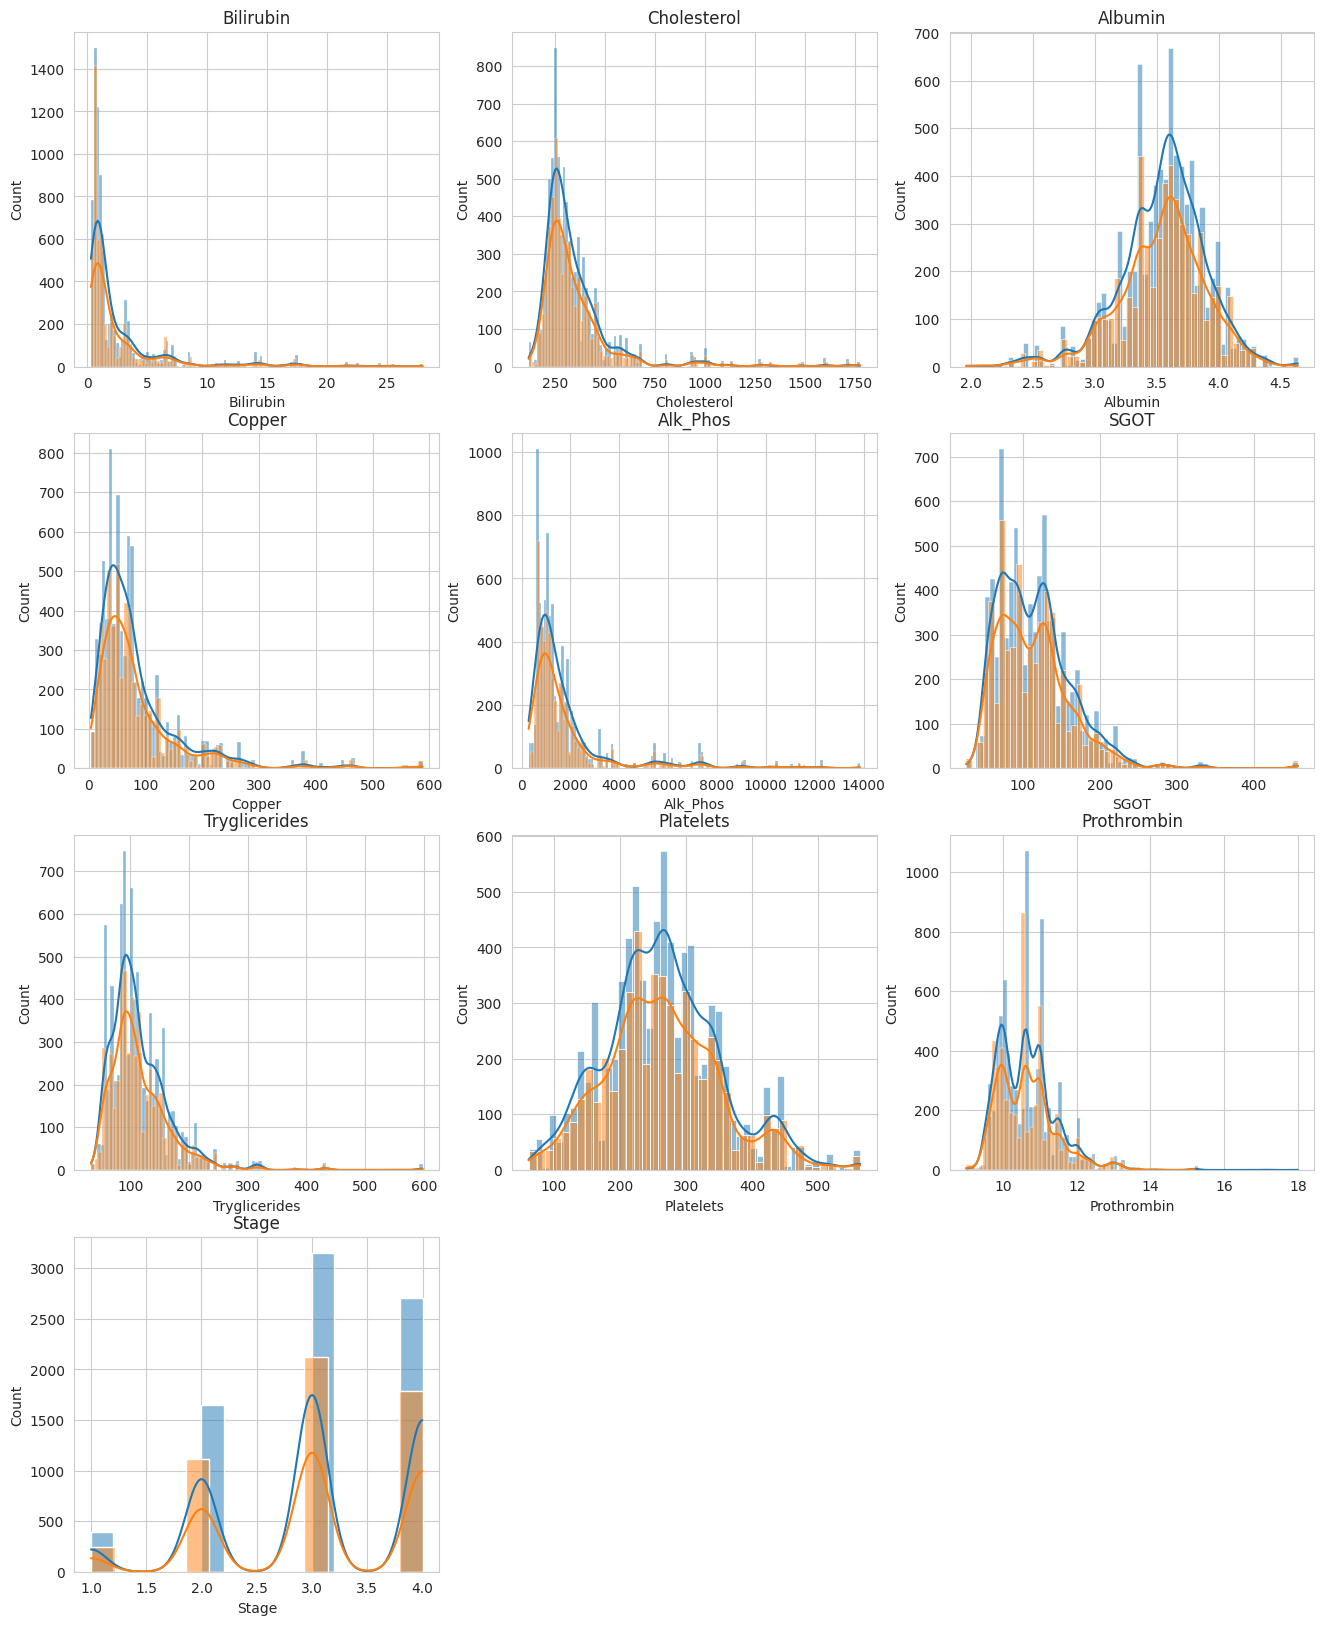

In [7]:
features = [col for col in train.columns if train[col].dtype=='float']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(16,5*rows)) 
for i,col in enumerate(features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)


### Takeaways
* Some features are skewed distributions
    * Try log transform

In [8]:
# features = [col for col in train.columns if train[col].dtype=='float']
# rows = int(np.ceil(len(features)/3)) 
# plt.figure(figsize=(16,5*rows)) 
# for i,col in enumerate(features): 
#   plt.subplot(rows,3,i+1) 
#   sns.violinplot(train[col],kde=True,hue=train.Status) 

#   plt.title(col)

## Target Distribtion

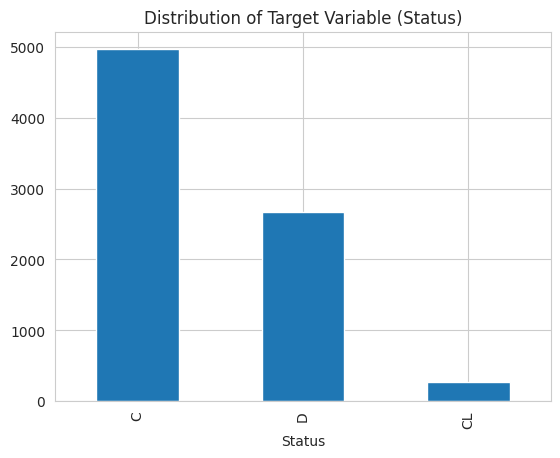

In [9]:
train.Status.value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable (Status)')
plt.show()

### Takeaways
* Imbalanced target classes means use stratified kfold 

# Data Transformations
* So, to make binary columns booleans, int8's, or define as categorical?
    * Good opportunity to test this.

<Axes: xlabel='Drug'>

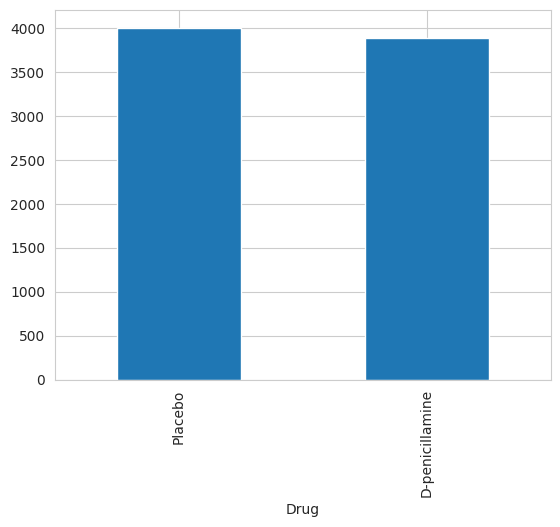

In [10]:
train.Drug.value_counts().plot(kind='bar')

In [11]:
# stage should be an int8
train.Stage = train.Stage.astype('int8')
test.Stage = test.Stage.astype('int8')

#train['Drug'] = train['Drug'].map({'D-penicillamine': True, 'Placebo': False}).astype('bool')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4,C


# Correlations

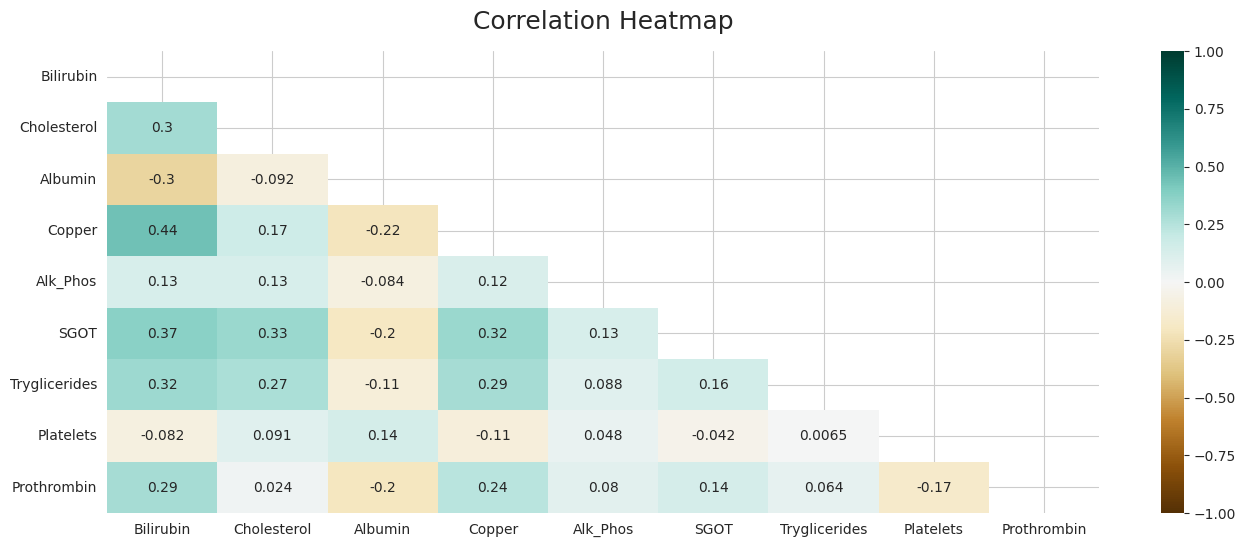

In [12]:
plt.figure(figsize=(16, 6)) 
float_feats = [col for col in train.columns if train[col].dtype=='float']
mask = np.triu(np.ones_like(train[float_feats].corr(),dtype=bool)) 
heatmap = sns.heatmap(train[float_feats].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

## Correlation with Target

In [13]:
# plt.figure(figsize=(8, 12)) # set size by num of features 
# heatmap = sns.heatmap(train[float_feats].corr()[['Status']].sort_values(by='Status', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
# heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);